# 리뷰 감성 분석

## 개요

- 사용 데이터: 쇼핑몰 리뷰 데이터

- 설계
| 태스크 | 기술 |
|----------------|-----------------------------|
| 데이터 전처리 | 데이터 로드, 전처리 |
| 사용 모델 | klue/roberta-base  |
| 훈련 | 정식 Fine-Tuning, Lora Fine-Tuning |

# 1. 데이터 전처리

In [ ]:
# 파일 경로 및 파일 읽기 라이브러리
import re
from pathlib import Path
from dataclasses import dataclass
import random
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from typing import Dict, List, Any, Tuple, Optional

# 파이토치 라이브러리
import torch

# 허깅페이스 관련 라이브러리
from datasets import (
    load_dataset,
    Dataset,
    DatasetDict
)
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from peft import (
    LoraConfig,
    get_peft_model,
    PeftModel,
    TaskType
    )
import evaluate

# 사이킷런
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 훈련 시 시각화
from tqdm import tqdm

/home/ahnhs2k/pytorch-demo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
"""
Config 클래스 정의

- 상수 변수 정의
- @dataclass 데코레이터 추가
"""
@dataclass
class Config:
    # 데이터 폴더 생성
    root = Path(".")
    raw_dir = root / "data"
    data_dir = raw_dir / "review-sentiment-analysis"
    model_dir = root / "models"

    # 데이터셋용 변수 선언
    max_len = 128
    test_size = 0.2

    # 랜덤 추출용 변수
    seed = 42

    # 학습용 변수 선언: 학습률, 에포크, 인내심, 최소 개선 폭
    lr = 2e-5
    epochs = 2
    batch = 64

    # 디바이스 설정
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # 후처리 함수 설정
    def __post_init__(self):
        self.raw_dir.mkdir(parents=True, exist_ok=True)
        self.data_dir.mkdir(parents=True, exist_ok=True)
        self.model_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# 변수 생성 및 폴더 생성
cfg = Config()

In [ ]:
"""
데이터 다운로드

- 미션 페이지에서 데이터 다운로드
"""
with zipfile.ZipFile(f"{str(cfg.raw_dir)}/review-sentiment-analysis.zip") as z:
    z.extractall(path=str(cfg.raw_dir))

In [ ]:
# JSON 파일 저장 함수
def save_jsonl(samples: List[Dict[str, str]], out_path: Path) -> None:
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with out_path.open("w", encoding="utf-8") as f:
        for s in samples:
            f.write(json.dumps(s, ensure_ascii=False) + "\n")

In [ ]:
# 데이터 통합 및 전처리 함수 생성
def unifing_data(data_dir: Path) -> List[Dict[str, int]]:
    """
    각 분할 파일을 하나로 정리

    Arg:
        Path: json 데이터가 포함된 디렉토리
              -1: 부정 | 0: 중립 | 1: 긍정

    Returns:
        unified: 각 원소는 {'text': str, 'label': int}
                 0: 부정 | 1: 중립 | 2: 긍정
    """
    unified = []
    for jfile in data_dir.rglob("*.json"):
        with open(jfile, "r", encoding="utf-8") as f:
            try:
                items = json.load(f)
                for item in items:
                    polarity = item.get("GeneralPolarity", None)
                    text = item.get("RawText", None)


                    if polarity is not None and text:  # 둘 다 있어야 추가
                        polarity = int(polarity)
                        if polarity in [-1, 0, 1]:
                            unified.append({
                                "text": text,
                                "label": polarity + 1 # 매핑 수정
                            })
            except Exception:
                continue  # 형식 위반 시 무시

    # set을 이용해 중복 제거
    def duplicate_remover(dlist: List[Dict[str, int]]) -> List[Dict[str, int]]:
        """
        Args:
            dlist: 사전을 요소로 가진 리스트

        Returns:
            result: set을 통해 중복을 제거한 리스트
        """
        record = set()
        result = []

        for item in dlist:
            value = item["text"]
            if value in record:
                continue
            record.add(value)
            result.append(item)

        return result

    unified = duplicate_remover(unified)

    return unified



In [ ]:
# 훈련 데이터 통합 및 전처리
train_normalized = unifing_data(cfg.data_dir)

In [ ]:
# 통합 및 전처리 데이터 예시 출력
print(f"통합 훈련 데이터 샘플: {train_normalized[0]}")

# 데이터 길이 확인
print(f"통합 훈련 데이터 길이: {len(train_normalized)}")

통합 훈련 데이터 샘플: {'text': '바지 하나 소개 해 드릴게요. 도시적이고 세련된 스타일의 바지랍니다.  무엇보다 디자인이 많이 고급집니다! 색상도 거의 블랙에 가까운 차콜색이라서 너무 좋습니다. 가격이 좀 사악하게 나와서 마음에 안 들면 반품해야지 하는 생각으로 구매했는데 어머나 색상 너무 좋고 핏 그리고 감촉까지도 제가 찾던 바지입니다. 일단 바지 재질이 부들부들하고 핏도 좋습니다. 길이감도 딱 좋아서 기장 수선 없이 입을 수 있습니다. 올해 이 바지만 주구장창 입을 듯 하네요.  여러분도 이 바지 한번 구입해서 입어보세요. 절대 후회하지 않으실 바지입니다.              ', 'label': 2}
통합 훈련 데이터 길이: 184525


In [ ]:
# 데이터프레임으로 변환
data_df = pd.DataFrame(train_normalized)
data_df

,text,label
0,바지 하나 소개 해 드릴게요. 도시적이고 세련된 스타일의 바지랍니다. 무엇보다 디...,2
1,안녕하세요. 날씨가 점점 추워지고 있는데 오늘은 일명 OO 패딩이라는 OOO 스투키...,2
2,필라테스를 시작하게 되어서 운동복으로 OOOO 레깅스를 구매 해 보았습니다. 사이...,2
3,작년에 입고 마음에 들어서 올해 재구매한 OOOO 와이드 바지입니다. 정말 편한 바...,2
4,겨울 코디에 빼 놓을 수 없는 게 코트 아닐까요? 그런데 날씨는 추워지는데 입을 만...,2
...,...,...
184520,처음 사용하는 태블릿PC인데 아담하니 휴대하기 편해서 너무 좋아요. 제품에 탁월한 ...,2
184521,사이즈가 딱좋아 편하게 들고 다니네요. 유심도 꼽아 쓸수 있고 여러모로 사용하기 최...,2
184522,OOO태블릿 쓰다가 아담한 OOO태블릿으로 쓰니까 컴팩트하니 좋아요. 그런데 장점만...,1
184523,기존꺼에서 새로운 태블릿PC로 바꿨더니 화면비율이 넓어져서 사용하는데 시원하니 좋네...,2


In [ ]:
# 라벨 분포와 편향도 확인
# 부정에 비해 긍정이 압도적으로 많은데, 데이터 split에서 조정이 필요해 보인다
data_df["label"].value_counts()

label
2    118870
1     37592
0     28063
Name: count, dtype: int64

In [ ]:
# 통합 데이터 저장
save_jsonl(train_normalized, cfg.data_dir / "unified_data.jsonl")
print("통합 데이터 파일 저장 완료!")

통합 데이터 파일 저장 완료!


## EXTRA: 데이터 추가 정제

- 댓글 알바 및 바이럴 마케팅으로 의심되는 긍정 리뷰를 정규식으로 검출하고 제거
- 타겟 표현: "안녕~", "오늘은~", "소개"
- 해당 표현이 들어갔으나 라벨은 긍정(2)이 아닐 가능성은 배제

In [ ]:
# 필터링 함수
def filter_and_clean_text(text: str) -> Tuple[str, Optional[str]]:
    """
    Args:
        text: 리뷰의 원문

    Returns:
        tuple: DROP 혹은 KEEP과 None 혹은 텍스트의 튜플
    """
    # 댓글 알바로 의심되는 리뷰 검출
    if re.search(r"(안녕|오늘은|소개)", text):
        return "DROP", None

    # 공백 정리
    text = re.sub(r"\s+", " ", text).strip()

    return "KEEP", text


In [ ]:
# 데이터셋 편집 함수
def my_editor(raw_list: List[Dict[str, int]]) -> List[Dict[str, int]]:
    """
    Args:
        raw_list: 편집 대상 리스트

    Returns:
        result: 편집 결과 리스트
    """
    result = []
    for item in raw_list:
        string = item["text"]
        label = item["label"]

        status, cleaned_text = filter_and_clean_text(string)

        # 댓글 알바 의심 대상이면서 리뷰가 긍정적이면 continue
        if status != "KEEP" and label == 2:
            continue

        result.append(item)

    return result


In [ ]:
# 편집 적용
edited_data = my_editor(train_normalized)

In [ ]:
# 데이터프레임으로 변환
edited_df = pd.DataFrame(edited_data)
edited_df

,text,label
0,필라테스를 시작하게 되어서 운동복으로 OOOO 레깅스를 구매 해 보았습니다. 사이...,2
1,작년에 입고 마음에 들어서 올해 재구매한 OOOO 와이드 바지입니다. 정말 편한 바...,2
2,겨울 코디에 빼 놓을 수 없는 게 코트 아닐까요? 그런데 날씨는 추워지는데 입을 만...,2
3,출산 후 임부복은 입기 싫고 임신 전 옷은 안 맞고 해서 집에서 운동할 때 입으려고...,2
4,날씨가 추워지니 기모 바지가 필요해서 구매했는데 너무나도 좋아서 후기 올려 봅니다....,2
...,...,...
179076,처음 사용하는 태블릿PC인데 아담하니 휴대하기 편해서 너무 좋아요. 제품에 탁월한 ...,2
179077,사이즈가 딱좋아 편하게 들고 다니네요. 유심도 꼽아 쓸수 있고 여러모로 사용하기 최...,2
179078,OOO태블릿 쓰다가 아담한 OOO태블릿으로 쓰니까 컴팩트하니 좋아요. 그런데 장점만...,1
179079,기존꺼에서 새로운 태블릿PC로 바꿨더니 화면비율이 넓어져서 사용하는데 시원하니 좋네...,2


In [ ]:
# 라벨 분포와 편향도 확인
# 184525 -> 179081개로 데이터가 줄어들었으며, 여전히 긍정 리뷰가 많긴 하지만 조금 간극이 줄어들었다.
edited_df["label"].value_counts()

label
2    113426
1     37592
0     28063
Name: count, dtype: int64

In [ ]:
# 정제된 데이터 저장
save_jsonl(edited_data, cfg.data_dir / "edited_data.jsonl")
print("편집 데이터 파일 저장 완료!")

편집 데이터 파일 저장 완료!


# 2. 데이터셋

In [ ]:
# JSONl 파일 로드 함수
def load_jsonl(json_path: Path) -> List[Dict[str, int]]:
    """
    Args:
        json_path: 저장 파일 경로

    Returns:
        data: JSONL에서 불러온 리스트
    """
    data: List[Dict[str, int]] = []
    with open(str(json_path), "r", encoding="utf-8") as j:
        for line in j:
            line = line.strip()
            if not line:
                continue
            data.append(json.loads(line))
    return data

In [ ]:
# 만들어둔 jsonl 파일 로딩 (oom에 대응하기 위해 저장 -> 불러오기 절차로 진행)
loaded_data = load_jsonl(cfg.data_dir / "edited_data.jsonl")

In [ ]:
# 데이터 split 및 허깅페이스 데이터셋으로 변환 함수 작성
def split_and_hf_dataset(lines: List,
                         label_key: str="label",
                         test_size: float=cfg.test_size,
                         seed: int=cfg.seed) -> DatasetDict:
    """
    Args:
        lines: 데이터가 담긴 리스트
        label_key: 데이터 분할 시 라벨 분포가 일정하도록 만들기 위한 라벨 키
        test_size: 검증 데이터 크기
        seed: 재현성 확보

    Returns:
        DatasetDict: 훈련과 검증 데이터가 담긴 허깅페이스 데이터셋
    """
    train, eval = train_test_split(
        lines,
        test_size=test_size,
        random_state=seed,
        shuffle=True,
        stratify=[line[label_key] for line in lines]
    )

    train_ds = Dataset.from_list(train)
    eval_ds = Dataset.from_list(eval)

    return DatasetDict({
        "train": train_ds,
        "eval": eval_ds
    })


In [ ]:
# 데이터셋 생성
ds = split_and_hf_dataset(loaded_data)

In [ ]:
# 샘플 확인
print(f"훈련: {ds["train"][0]}")
print(f"검증: {ds["eval"][0]}")

훈련: {'text': '소비자들이 가장 많이 사용하는 상품중 고르고 고른 상품 중 하나입니다.  솔이 튼튼해서 오래 사용할 것 같습니다. 바닥을 쓸어내릴 때 머리카락이 솔에 끼지 않아서 참 좋은 것 같습니다. 이곳저곳 다용도로 사용하기에 참 좋은 것 같습니다. 워낙 ㅇㅇ이 유명해서 궁금해서 구매해본건데 잘 구매한 것 같습니다. 가격이 비싸지만 성능이 정말 우수한 것 같습니다. 다만 손잡이부분이 미끄러워서 사용감이 조금 불편합니다.  포스팅을 보시고 더 좋은 선택을 할수 있는 의미있는 글이였으면 좋겠네요.  ', 'label': 1}
검증: {'text': '무선이라 이동도 쉽고 필요할때 바로 사용 가능하니 너무 편해요. 소음이 약간 있어요. 생각보다 크지 않아 만족해요. 배터리 용량이 적어 오래 사용못해 충전을 자주하게 됩니다. ㅠ.ㅠ', 'label': 1}


In [ ]:
# 모델 이름 정의 및 토크나이저 초기화
model_name = "klue/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# 토큰화 전처리 함수 생성
def preprocess(line):
    return tokenizer(
        line["text"],
        truncation=True,
        padding="max_length",
        max_length=cfg.max_len
    )

In [ ]:
# 토큰화된 데이터셋 생성
tokenized_ds = ds.map(preprocess, batched=True)
tokenized_ds

Map: 100%|██████████| 35817/35817 [00:01<00:00, 26957.12 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 143264
    })
    eval: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 35817
    })
})

In [ ]:
# set format으로 torch.Tensor로 설정
tokenized_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"],
)

In [ ]:
print(type(tokenized_ds["train"]["input_ids"][0]))

<class 'torch.Tensor'>


# 3. Full Fine-Tuning

In [ ]:
# 훈련 평가 함수 생성
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    """
    eval_pred: transformers.trainer_utils.EvalPrediction 객체
               내부적으로 (predictions, label_ids) 튜플처럼 동작함

    eval_pred.predictions: np.ndarray
        shape = (batch_size, num_labels)
        예: (128, 3)
        -> 각 클래스에 대한 로짓 값

    eval_pred.label_ids: np.ndarray
        shape = (batch_size,)
        dtype = int64
        예: [0, 2, 1, 0, ...]
    """

    # Trainer에서 eval_pred를 튜플처럼 언패킹
    logits, labels = eval_pred
    # logits: np.ndarray
    #   shape = (N, num_labels)
    # labels: np.ndarray
    #   shape = (N,)

    # 각 샘플에 대해 가장 큰 로짓 값을 가진 클래스 인덱스 선택
    preds = np.argmax(logits, axis=-1)
    # preds: np.ndarray (int64)
    #   shape = (N,)
    #   값 예: [2, 0, 1, 1, ...]

    # accuracy metric 계산
    # predictions: np.ndarray[int]
    # references: np.ndarray[int]
    acc_result = accuracy.compute(
        predictions=preds,
        references=labels
    )
    # acc_result: dict
    # {"accuracy": float}

    # macro F1 score 계산 (클래스 불균형 고려)
    f1_result = f1.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )
    # f1_result: dict
    # {"f1": float}

    # Trainer가 로그 및 저장에 사용할 dict 반환
    return {
        "accuracy": acc_result["accuracy"],  # float
        "macro_f1": f1_result["f1"],         # float
    }


In [ ]:
# 풀파인튜닝용 모델 초기화
model_ft = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 훈련 인자
training_args_ft = TrainingArguments(
    output_dir=f"{str(cfg.model_dir)}/roberta_base_full_ft",

    # 평가 / 저장 전략
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,

    # best model 저장
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,

    # 학습 설정
    learning_rate=cfg.lr,
    warmup_ratio=0.1,
    per_device_train_batch_size=cfg.batch,
    per_device_eval_batch_size=cfg.batch,
    num_train_epochs=cfg.epochs,
    seed=cfg.seed,

    # 저장 모델 이름
    run_name="roberta_base_full_ft",

    report_to="none",
)

In [ ]:
# 훈련 구성
trainer_ft = Trainer(
    model=model_ft,
    args=training_args_ft,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["eval"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

# 훈련 실행
trainer_ft.train()

/tmp/ipykernel_387646/676530883.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_ft = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.237200,0.217427,0.910043,0.884019
2,0.182700,0.211425,0.914733,0.887697


TrainOutput(global_step=4478, training_loss=0.2380054639140747, metrics={'train_runtime': 1009.7524, 'train_samples_per_second': 283.761, 'train_steps_per_second': 4.435, 'total_flos': 1.8847340338692096e+16, 'train_loss': 0.2380054639140747, 'epoch': 2.0})

In [ ]:
# 모델 불러오기
tokenizer_ft = AutoTokenizer.from_pretrained(f"{str(cfg.model_dir)}/roberta_base_full_ft/checkpoint-4478")
model_ft = AutoModelForSequenceClassification.from_pretrained(f"{str(cfg.model_dir)}/roberta_base_full_ft/checkpoint-4478")

# 4. Lora Fine-Tuning

In [ ]:
# Lora 파인튜닝용 모델 초기화
model_peft = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# LoRA config 설정
lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=["query", "value"],
        bias="none",
    )

In [ ]:
# LoRA 모델 생성
lora_model = get_peft_model(model_peft, lora_config)

In [ ]:
# 학습 파라미터 수 출력
lora_model.print_trainable_parameters()

trainable params: 887,811 || all params: 111,508,230 || trainable%: 0.7962


In [ ]:
# 훈련 인자
training_args_lora = TrainingArguments(
    output_dir=f"{str(cfg.model_dir)}/roberta_base_lora_ft",

    # 평가 / 저장 전략
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,

    # best model 저장
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,

    # 학습 설정
    learning_rate=2e-4, # lora는 학습 파라미터가 적으므로 full fine-tuning보다 학습률 높게 설정
    warmup_ratio=0.1,
    per_device_train_batch_size=cfg.batch,
    per_device_eval_batch_size=cfg.batch,
    num_train_epochs=cfg.epochs,
    seed=cfg.seed,

    # 저장 모델 이름
    run_name="roberta_base_lora_ft",

    report_to="none",
)

In [ ]:
# 훈련 구성
trainer_lora = Trainer(
    model=lora_model,
    args=training_args_lora,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["eval"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

# 훈련 실행
trainer_lora.train()

/tmp/ipykernel_548924/873207589.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.262000,0.242912,0.899908,0.868172
2,0.237100,0.231738,0.904459,0.875558


TrainOutput(global_step=4478, training_loss=0.27894451384993735, metrics={'train_runtime': 810.7972, 'train_samples_per_second': 353.39, 'train_steps_per_second': 5.523, 'total_flos': 1.904270626013184e+16, 'train_loss': 0.27894451384993735, 'epoch': 2.0})

In [ ]:
# 모델 불러오기
tokenizer_lora = AutoTokenizer.from_pretrained(f"{str(cfg.model_dir)}/roberta_base_lora_ft/checkpoint-4478")
lora_model = PeftModel.from_pretrained(model_peft, f"{str(cfg.model_dir)}/roberta_base_lora_ft/checkpoint-4478")

# 5. 추론 및 평가

In [ ]:
# 테스트용 스트링
text_sample = "배송은 빠른데 제품 성능은 별로네요"

# 라벨 매핑
label_map = {0: "negative", 1: "neutral", 2: "positive"}

In [ ]:
# Full Fine-Tuning 추론 예시
model_ft.to(cfg.device)

inputs_ft = tokenizer_ft(
    text_sample,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=128,
)

inputs_ft = {k: v.to(cfg.device) for k, v in inputs_ft.items()}

model_ft.eval()
with torch.no_grad():
    outputs_ft = model_ft(**inputs_ft)

pred_ft = torch.argmax(outputs_ft.logits, dim=-1).item()

print(label_map[pred_ft])

negative


In [ ]:
# Lora Fine-Tuning 추론 예시
lora_model.to(cfg.device)

inputs_lora = tokenizer_lora(
    text_sample,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=128,
)

inputs_lora = {k: v.to(cfg.device) for k, v in inputs_lora.items()}

lora_model.eval()
with torch.no_grad():
    outputs_lora = lora_model(**inputs_lora)

pred_lora = torch.argmax(outputs_lora.logits, dim=-1).item()

print(label_map[pred_lora])

negative


In [ ]:
def inference_and_plot_confusion_matrix(
    model,
    eval_dataset,
    batch_size=cfg.batch,
    label_names=["negative", "neutral", "positive"],
    normalize="true",
    device=cfg.device
):
    """
    Args:
        model: 로드된 분류 모델 (Full FT 또는 LoRA)
        eval_dataset: tokenized 검증 데이터셋
        batch_size: 추론 배치 사이즈
        label_names : 클래스 이름
        normalize : {"true", "pred", "all", None}
        혼동행렬 정규화 방식
    """
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i in range(0, len(eval_dataset), batch_size):
            batch = eval_dataset[i : i + batch_size]

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"]

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )

            preds = torch.argmax(outputs.logits, dim=-1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # 맞는 분류
    print("맞은 분류 예시 3개")
    correct_indices = np.where(all_preds == all_labels)[0][:3]
    for i in correct_indices:
        print("원문:", eval_dataset["text"][i])
        print(
            "실제:", label_map[int(all_labels[i])],
            "예측:", label_map[int(all_preds[i])]
        )
        print("-" * 40)

    # 오분류 예시
    print("오분류 예시 3개")
    wrong_indices = np.where(all_preds != all_labels)[0][:3]
    for i in wrong_indices:
        print("원문:", eval_dataset["text"][i])
        print(
            "실제:", label_map[int(all_labels[i])],
            "예측:", label_map[int(all_preds[i])]
        )
        print("-" * 40)

    # 혼동행렬
    cm = confusion_matrix(all_labels, all_preds, normalize=normalize)

    # 시각화
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=label_names,
    )
    disp.plot(
        cmap="Blues",
        values_format=".2f" if normalize else "d",
        ax=ax,
        colorbar=True,
    )

    ax.set_title(
        f"Confusion Matrix (normalize={normalize})"
        if normalize
        else "Confusion Matrix (raw counts)"
    )
    plt.tight_layout()
    plt.show()

    return cm

맞은 분류 예시 3개
원문: 무선이라 이동도 쉽고 필요할때 바로 사용 가능하니 너무 편해요. 소음이 약간 있어요. 생각보다 크지 않아 만족해요. 배터리 용량이 적어 오래 사용못해 충전을 자주하게 됩니다. ㅠ.ㅠ
실제: neutral 예측: neutral
----------------------------------------
원문: 키감이 아주 쫀득하니 딱 맘에 들어 잘 쓰고 있습니다.  한/영 변환 키 위치가 이전에 쓰던 위치와 좀 차이가 나서 쓸 때마다 버벅되네요.
실제: neutral 예측: neutral
----------------------------------------
원문: 절대 비추 제품~! 캠핑장에서 사용하다 전기 차단기 내려가 쓰지도 못하고 주위분들께 불편만 주고 왔어요. ㅜ 품질 꽝  전기를 얼마나 먹으면 차단기가 내려갈까요. ㅜ 전기소비효율이 꽝입니다.  사지 마세요. 절대~!
실제: negative 예측: negative
----------------------------------------
오분류 예시 3개
원문: 리모컨으로 작동 시킬 수 있어서 편리해요~ 바람도 완전 시원하니 성능 마음에 쏙 들어요~ 무선이 아니라서 아쉽긴 하지만...
실제: neutral 예측: positive
----------------------------------------
원문: 거품이잘나고두피도시원하고향도마음에드는데머리말리고나니약간뻣뻣하네요
실제: positive 예측: neutral
----------------------------------------
원문: 사진에서는  무척 고급스럽고  예뻤는데 실물로 보니 덜 예쁘네요. 그래도 편해서 좋아요.
실제: positive 예측: neutral
----------------------------------------


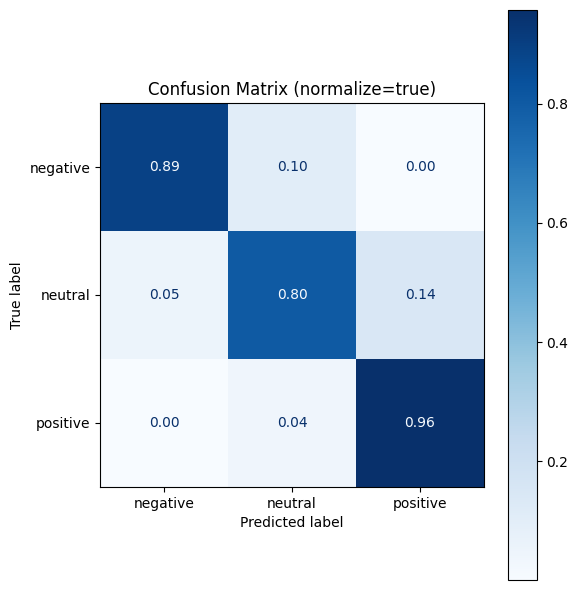

In [ ]:
# Full Fine-Tuning 혼동행렬
cm_ft = inference_and_plot_confusion_matrix(
    model=model_ft,
    eval_dataset=tokenized_ds["eval"],
)

맞은 분류 예시 3개
원문: 무선이라 이동도 쉽고 필요할때 바로 사용 가능하니 너무 편해요. 소음이 약간 있어요. 생각보다 크지 않아 만족해요. 배터리 용량이 적어 오래 사용못해 충전을 자주하게 됩니다. ㅠ.ㅠ
실제: neutral 예측: neutral
----------------------------------------
원문: 키감이 아주 쫀득하니 딱 맘에 들어 잘 쓰고 있습니다.  한/영 변환 키 위치가 이전에 쓰던 위치와 좀 차이가 나서 쓸 때마다 버벅되네요.
실제: neutral 예측: neutral
----------------------------------------
원문: 절대 비추 제품~! 캠핑장에서 사용하다 전기 차단기 내려가 쓰지도 못하고 주위분들께 불편만 주고 왔어요. ㅜ 품질 꽝  전기를 얼마나 먹으면 차단기가 내려갈까요. ㅜ 전기소비효율이 꽝입니다.  사지 마세요. 절대~!
실제: negative 예측: negative
----------------------------------------
오분류 예시 3개
원문: 리모컨으로 작동 시킬 수 있어서 편리해요~ 바람도 완전 시원하니 성능 마음에 쏙 들어요~ 무선이 아니라서 아쉽긴 하지만...
실제: neutral 예측: positive
----------------------------------------
원문: 생각보다 많이 얇아요 재질은 부드러워 좋은데 세탁해봤는데 목부분은 금방 늘어질것같아요 ㅠ
실제: negative 예측: neutral
----------------------------------------
원문: 신발은 예뻐요 발등이 좀 아퍼요 내발이 문젠지~암튼 좋은가격에 잘 신을께요
실제: positive 예측: neutral
----------------------------------------


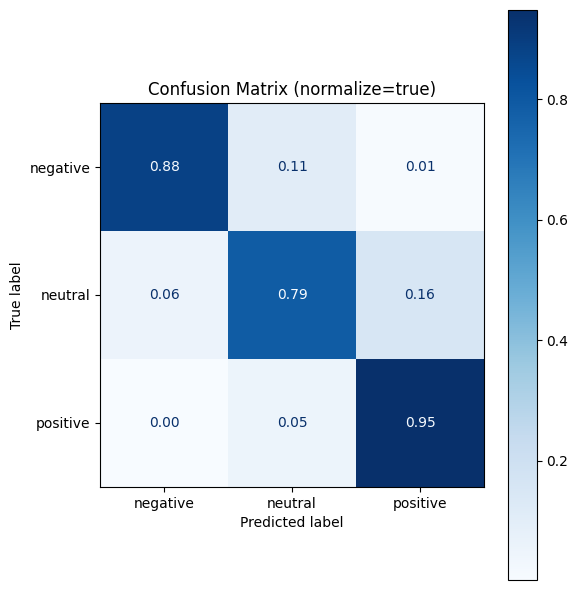

In [ ]:
# Lora Fine-Tuning 혼동행렬
cm_lora = inference_and_plot_confusion_matrix(
    model=lora_model,
    eval_dataset=tokenized_ds["eval"],
)

## 5.1. 코멘트

- 2 에포크라는 적은 수의 에포크를 돌렸지만, 예측 결과의 점수가 이미 높았고 Full 파인튜닝과 Lora 파인튜닝의 차이를 확인하기에 충분하다고 생각하기에 추가 훈련을 돌리지는 않았습니다.
- Full 파인튜닝은 훈련 완료까지 16:48가 걸렸으며, (1) 정확도 0.914733, (2) 매크로 F1 0.887697를 달성했습니다.
- Lora 파인튜닝은 훈련 완료까지 13:30가 걸렸으며, (1) 정확도 0.904459, (2) 매크로 F1 0.875558를 달성했습니다.
- 모델 예측의 정확도에서는 Full 파인튜닝 모델이 Lora 파인튜닝 모델보다 우수했습니다.
- 훈련 시간이라는 측면에서는 약 3분 이상의 차이가 났으며, 훈련 에포크가 더 많아지면 차이가 더 벌어질 것으로 생각됩니다.
